In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, vmap, grad, jit
import jax.scipy as jscp
from jax.lax import scan, stop_gradient
import flax
import flax.linen as nn
import optax

import itertools
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Overdamped Langevin Dynamics

In [3]:
def SingleParPull(t, num_sim, param_eta, param_k, param_kB_T, param_u, param_mu, param_sigma, seed, sin_pull=True):
	'''
	param_mu: mean of initial distribution
	param_sigma: std of initial distribution
	'''
	# t is a 1D vector
	Nt = t.shape[0] # number of time mesh
	Nx = num_sim

	X = onp.zeros((Nt,Nx))  # displacement field

	# sample from initial distribution
	key = random.PRNGKey(seed)
	X[0,:] = param_mu + param_sigma * random.normal(key, (Nx,))
	
	vel = onp.zeros((Nt,Nx)) # velocity field
	Fex = onp.zeros((Nt,Nx)) # external force
	if sin_pull == True:
		lambda_t = param_u * t * (1.0 - onp.exp(-t)) * (1.0 + 2.0 * onp.sin(2.0 * onp.pi * t)) # pulling protocol
	else:
		lambda_t = param_u * t * (1.0 - onp.exp(-t))

	coeff_Brownian = onp.sqrt(2.0 * param_kB_T / param_eta)
	k_by_eta = param_k / param_eta 

	for i in range(Nt-1):
		dt = t[i+1] - t[i]

		# sample from a Gaussian distribution
		key, subkey = random.split(key) # generate a new key
		dBt = coeff_Brownian * random.normal(subkey, (Nx,)) 

		# update position and velocity
		X[i+1,:] = X[i,:] - k_by_eta * (2.0*X[i,:] - lambda_t[i]) * dt + dBt * onp.sqrt(dt)
		vel[i+1,:] = (X[i+1,:] - X[i,:]) / dt
		Fex[i+1,:] = param_k * (lambda_t[i+1] - X[i+1,:])

	return X, vel, Fex

# IB

## MLP

In [4]:
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for size in self.layers[:-1]:
            x = nn.Dense(size)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layers[-1])(x)
        return x

class INN_MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for size in self.layers[:-1]:
            x = nn.Dense(size)(x)
            x = nn.softplus(x)
        x = nn.Dense(self.layers[-1])(x)
        return x
    
class PICINN_MLP(nn.Module):
    layers: list
    def setup(self):
        self.in_size = self.layers[0]
        self.out_size = self.layers[-1]
        self.hidden_layers = self.layers[1:-1]
        self.num_layers = len(self.hidden_layers)

    @nn.compact
    def __call__(self, w, z): # convext, non-convex
        z_size = z.shape[-1]                 # Size of the input z
        w_size = w.shape[-1]                 # Size of the input w
        input_z = z.reshape(-1, z_size)  # Shape: (batch_size, z_size)
        input_w = w.reshape(-1, w_size)            # Shape: (batch_size, w_size)

        # Input layer parameters
        W_zx = self.param('input_layer_w_zx', nn.initializers.xavier_uniform(), (z_size, self.hidden_layers[0]))
        b_zx = self.param('input_layer_b_zx', nn.initializers.zeros, (self.hidden_layers[0],))
        W_x = self.param('input_layer_w_x', nn.initializers.xavier_uniform(), (z_size, self.hidden_layers[0]))
        W_w = self.param('input_layer_w_w', nn.initializers.xavier_uniform(), (w_size, self.hidden_layers[0]))
        W_wx = self.param('input_layer_w_wx', nn.initializers.xavier_uniform(), (z_size, w_size))
        b_wx = self.param('input_layer_b_wx', nn.initializers.zeros, (w_size,))
        b = self.param('input_layer_b', nn.initializers.zeros, (self.hidden_layers[0],))

        # Input layer computations
        x_hidden = nn.softplus(np.dot(input_z, W_zx) + b_zx)
        y_hidden = nn.softplus(np.dot(np.multiply(input_w, np.dot(input_z, W_wx) + b_wx), W_w) + np.dot(input_z, W_x) + b)

        # Hidden layers computations
        for i in range(self.num_layers - 1):
            W_zx = self.param(f'hidden_layers_w_zx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            b_zx = self.param(f'hidden_layers_b_zx_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))
            
            W_x = self.param(f'hidden_layers_w_x_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            
            W_y = self.param(f'hidden_layers_w_y_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            # Constrain the weights to be non-negative
            W_y = np.where(W_y < 0, np.exp(W_y - 5.0), W_y + np.exp(-5.0))
            
            W_yx = self.param(f'hidden_layers_w_yx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            b_yx = self.param(f'hidden_layers_b_yx_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))
            
            W_w = self.param(f'hidden_layers_w_w_{i}', nn.initializers.xavier_uniform(), (w_size, self.hidden_layers[i+1]))
            
            W_wx = self.param(f'hidden_layers_w_wx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], w_size))
            b_wx = self.param(f'hidden_layers_b_wx_{i}', nn.initializers.zeros, (w_size,))
            
            b = self.param(f'hidden_layers_b_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))

            # Update hidden layers
            y_hidden = nn.softplus(np.dot(np.multiply(y_hidden, nn.softplus(np.dot(x_hidden, W_yx) + b_yx)), W_y.T) \
                                    + np.dot(np.multiply(input_w, np.dot(x_hidden, W_wx) + b_wx), W_w) + np.dot(x_hidden, W_x) + b)
            x_hidden = nn.softplus(np.dot(x_hidden, W_zx) + b_zx)

        # Output layer parameters
        W_x = self.param('output_layer_w_x', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))         
        
        W_yx = self.param('output_layer_w_yx', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))
        b_yx = self.param('output_layer_b_yx', nn.initializers.zeros, (self.out_size,))
        
        W_y = self.param('output_layer_w_y', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))
        # Constrain the weights to be non-negative
        W_y = np.where(W_y < 0, np.exp(W_y - 5.0), W_y + np.exp(-5.0))
        
        W_w = self.param('output_layer_w_w', nn.initializers.xavier_uniform(), (w_size, self.out_size))
        
        W_wx = self.param('output_layer_w_wx', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], w_size))
        b_wx = self.param('output_layer_b_wx', nn.initializers.zeros, (w_size,))
        
        b = self.param('output_layer_b', nn.initializers.zeros, (self.out_size,))

        # Final output computation
        y_out = np.dot(np.multiply(y_hidden, nn.softplus(np.dot(x_hidden, W_yx) + b_yx)), W_y) \
                + np.dot(np.multiply(input_w, np.dot(x_hidden, W_wx) + b_wx), W_w) + np.dot(x_hidden, W_x) + b
        return y_out  # Return scalar output

## Past-future IB



In [5]:
class IB():
	def __init__(self, dataset, layers_encoder, layers_encoder2, layers_fe, layers_phi, layers_decoder, time_delay, rng_key = random.PRNGKey(0)):
		# load training data
		self.t = dataset[0]	
		self.delta_t = self.t[1] - self.t[0]
		self.t = onp.reshape(self.t,[1,-1])
		self.X = dataset[1]
		self.Fex = dataset[2]
		self.lambda_t = dataset[3]
		self.lambda_t = self.lambda_t[:,:,None]
		self.k = dataset[4]
		self.eta = dataset[5]

		# length of the dataset
		self.Nu = self.X.shape[0]
		self.Nt = self.X.shape[1]
		self.Nsim = self.X.shape[2]

		# scaling X
		self.X_mean = self.X.mean()
		self.X_std = self.X.std()

		# used for vectorization
		self.ones = onp.ones([1,1,self.Nsim])

		# set delta t (should be an integer)
		self.time_delay = time_delay

		# set up encoder and decoder network initialization and evaluation functions
		self.nn_encoder = MLP([1] + layers_encoder)
		self.nn_encoder2 = MLP(layers_encoder2)
		self.nn_fe = INN_MLP(layers_fe)
		self.nn_phi = PICINN_MLP(layers_phi) 
		# Gaussian microscopic distribution
		self.nn_decoder = MLP(layers_decoder + [2])
		
		# Initialize parameters
		self.rng_key = rng_key
		_, subkey1, subkey2, subkey3, subkey4, subkey5 = random.split(rng_key, 6)
		params_encoder = self.nn_encoder.init(subkey1, np.ones([1]))
		params_encoder2 = self.nn_encoder2.init(subkey2, np.ones([layers_encoder2[0]]))
		params_fe = self.nn_fe.init(subkey3, np.ones([2]))
		params_phi = self.nn_phi.init(subkey4, np.ones([1]), np.ones([1]))
		params_decoder = self.nn_decoder.init(subkey5, np.ones([1]))
		self.params = {'encoder': params_encoder, 'encoder2': params_encoder2, 'fe': params_fe, 'phi': params_phi, 'decoder': params_decoder}
 
		# scales
		self.fe_scale = self.Fex.std() * self.lambda_t.std() 
		self.phi_scale = self.fe_scale * 1.0 / 1.0
		self.lambda_t_mean = self.lambda_t.mean()
		self.lambda_t_std = self.lambda_t.std()
		self.internal_var_mean = 0.0
		self.internal_var_std = 1.0
		self.g_internal_var_dot_scale = self.phi_scale / 1.0
		self.g_internal_var_dot_mean = 0.0 
		self.lambda_t_zero = self.lambda_t[0,:1,0]
		self.internal_var_zero = np.zeros(1)

		# normalizing factors
		self.norm_fac_alpha = self.X_mean, self.X_std
		self.norm_fac_fe = self.lambda_t_mean, self.lambda_t_std, self.internal_var_mean, self.internal_var_std, self.fe_scale, self.lambda_t_zero, self.internal_var_zero
		self.norm_fac_phi = self.internal_var_mean, self.internal_var_std, self.g_internal_var_dot_mean, self.g_internal_var_dot_scale, self.phi_scale
		
		# loss weights
		self.factor_m_log = 1e-5
		self.factor_Fex = 1.0
		self.factor_alpha = 1.0

        # Set up optimizer
		self.opt_init, self.opt_update = optax.adam(5e-5) #5e-5
		self.opt_state = self.opt_init(self.params)

		# Logger to monitor the loss function
		self.loss_log = []
		self.loss_pdf_log = []
		self.loss_Fex_log = []
		self.loss_alpha_log = []
		self.itercount = itertools.count()

		# vmap and jit 
		self.vec_calc_fe = vmap(vmap(self.net_fe,in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
		self.vec_calc_phi = vmap(vmap(self.net_phi,in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
		self.vec_calc_dfe_dlambda_t = vmap(vmap(grad(self.net_fe, 1),in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
		self.vec_calc_dfe_dinternal = vmap(vmap(grad(self.net_fe, 2),in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
		self.vec_calc_dphi_dg_internal_dot = vmap(vmap(grad(self.net_phi, 1),in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
		self.get_loss = jit(self._get_loss)
		self.step = jit(self._step)

  	# calc free energy fe for given lambda_t, internal var
	def net_fe(self, params_fe, lambda_t, internal_var, norm_fac):
		lambda_t_mean, lambda_t_std, internal_var_mean, internal_var_std, fe_scale, _, _ = norm_fac
    	# normalizing input
		lambda_t = (lambda_t - lambda_t_mean) / lambda_t_std
		internal_var = (internal_var - internal_var_mean) / internal_var_std
		inputs = np.concatenate([lambda_t,internal_var],axis=0)
		fe = self.nn_fe.apply(params_fe, inputs) 
		return (fe[0]) * fe_scale

  	# calc dissipation potential psi for given v
	def net_phi_no_zero_fix(self, params_phi, g_internal_var_dot, internal_var, norm_fac):
		internal_var_mean, internal_var_std, g_internal_var_dot_mean, g_internal_var_dot_scale, _ = norm_fac
		# normalizing input
		g_internal_var_dot = (g_internal_var_dot - g_internal_var_dot_mean) / g_internal_var_dot_scale
		internal_var = (internal_var - internal_var_mean) / internal_var_std
		phi = self.nn_phi.apply(params_phi, g_internal_var_dot, internal_var) 
		return phi[0][0] 

	def net_phi(self, params_phi, g_internal_var_dot, internal_var, norm_fac):
		_, _, _, _, phi_scale = norm_fac
		phi = self.net_phi_no_zero_fix(params_phi, g_internal_var_dot, internal_var, norm_fac)
		phi_zero = self.net_phi_no_zero_fix(params_phi, np.zeros(1), internal_var, norm_fac)
		dphi_fix = grad(self.net_phi_no_zero_fix,1)(params_phi, np.zeros(1), internal_var, norm_fac) * g_internal_var_dot
		return (phi - phi_zero - dphi_fix)[0] * phi_scale
	
	def calc_internal_var(self, params_encoder, params_encoder2, X_input, norm_fac):
		X_mean, X_std = norm_fac
		X_input_scaled = (X_input - X_mean) / X_std		
		internal_var = self.nn_encoder.apply(params_encoder, X_input_scaled).mean(axis=-2)
		internal_var = self.nn_encoder2.apply(params_encoder2, internal_var)
		return internal_var
	
	def calc_pdf(self, params_decoder, internal_var, norm_fac):
		predict_mean_std = self.nn_decoder.apply(params_decoder, internal_var) 
		X_mean, X_std = norm_fac
		predict_mean = predict_mean_std[:,:,:1] * X_mean
		predict_std = predict_mean_std[:,:,1:] * X_std
		return predict_mean, predict_std

  	# function of the scan loop
	def time_int(self, states, lambda_t):
		params_fe, params_phi, alpha, norm_fac_fe, norm_fac_phi, delta_t = states
		lambda_t = lambda_t[:,:,None]
		# calc derivatives
		g_internal_var_dot = -self.vec_calc_dfe_dinternal(params_fe, lambda_t, alpha, norm_fac_fe)
		# predict alpha dot
		alpha_dot_nn = self.vec_calc_dphi_dg_internal_dot(params_phi, g_internal_var_dot, alpha, norm_fac_phi)
		alpha_dot_nn = np.clip(alpha_dot_nn, a_min=-30.0, a_max=30.0)
		# update states
		alpha = alpha + alpha_dot_nn * delta_t
		return (params_fe, params_phi, alpha, norm_fac_fe, norm_fac_phi, delta_t), alpha 

	# return loss
	def _get_loss(self, params, batch):
		params_encoder = params['encoder']
		params_encoder2 = params['encoder2']
		params_fe = params['fe']
		params_phi = params['phi']
		params_decoder = params['decoder']
		norm_fac_alpha, norm_fac_fe, norm_fac_phi, factor_m_log, factor_Fex, factor_alpha, X_input, lambda_t, _Fex, ones, delta_t = batch
		
		alpha = self.calc_internal_var(params_encoder, params_encoder2, X_input, norm_fac_alpha)
    
		# L2 loss trajectory of internal var
		init = params_fe, params_phi, alpha[:,:1,:], norm_fac_fe, norm_fac_phi, delta_t
		_, alpha_nn = scan(self.time_int, init, np.transpose(lambda_t[:,1:,:],axes=[1,0,2]))
		alpha_nn = np.transpose(alpha_nn[:,:,:,0],axes=[1,0,2]) 
		loss_alpha = ((alpha[:,1:,:] - alpha_nn)**2).mean() 

		# L2 loss Fex
		dfe_dlambda_t = self.vec_calc_dfe_dlambda_t(params_fe, lambda_t[:,1:,:], alpha_nn, norm_fac_fe)
		loss_Fex = ((dfe_dlambda_t - _Fex[:,1:,None])**2).mean() 

		# microscopic pdf
		predict_mean, predict_std = self.calc_pdf(params_decoder, alpha, norm_fac_alpha)
		m_log_pdf = - (jscp.stats.norm.logpdf(X_input[:,:,:,0], loc=(predict_mean*ones), scale=(predict_std*ones))).mean()
		
		loss = factor_m_log * m_log_pdf + factor_Fex * loss_Fex  + factor_alpha * loss_alpha
		return loss, m_log_pdf, loss_Fex, loss_alpha
	
	def loss(self, params, batch):
		loss, _, _, _ = self.get_loss(params, batch)
		return loss

    # Define a compiled update step
	def _step(self, params, opt_state, batch):
		g = grad(self.loss)(params, batch)
		updates, opt_state = self.opt_update(g, opt_state)
		params = optax.apply_updates(params, updates)
		return params, opt_state

	def train(self, num_epochs = 100):   
		pbar = trange(num_epochs)
		for epoch in pbar:
			# mini-batch
			self.rng_key, _ = random.split(self.rng_key)
			id_t = random.randint(self.rng_key, (1,), minval=0, maxval=self.Nt-self.time_delay)[0]
			batch = self.norm_fac_alpha, self.norm_fac_fe, self.norm_fac_phi, self.factor_m_log, self.factor_Fex, self.factor_alpha, \
					self.X[:,id_t:id_t+self.time_delay,:,:], self.lambda_t[:,id_t:id_t+self.time_delay,:], self.Fex[:,id_t:id_t+self.time_delay], self.ones, self.delta_t

			self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
			loss, loss_pdf, loss_Fex, loss_alpha = self.get_loss(self.params, batch)
			self.loss_log.append(loss)
			self.loss_pdf_log.append(loss_pdf)
			self.loss_Fex_log.append(loss_Fex)
			self.loss_alpha_log.append(loss_alpha)
			if epoch % 100 == 0:
				print("\n loss = {}".format(loss))
    
	def get_all_params(self):
		params_encoder = self.params['encoder']
		params_encoder2 = self.params['encoder2']
		params_fe = self.params['fe']
		params_phi = self.params['phi']
		params_decoder = self.params['decoder']
		return params_encoder, params_encoder2, params_fe, params_phi, params_decoder, self.params

	def get_predicted_mean_std(self, X_input):
		params_encoder, params_encoder2, _, _, params_decoder, _ = self.get_all_params()
		alpha = self.calc_internal_var(params_encoder, params_encoder2, X_input, [self.X_mean, self.X_std])
		predict_mean, predict_std = self.calc_pdf(params_decoder, alpha, [self.X_mean, self.X_std])
		return predict_mean, predict_std
	
	def get_test_fe_phi_solve_OVP(self, lambda_t, X_input, mode="potential"):
		params_encoder, params_encoder2, params_fe, params_phi, _, _ = self.get_all_params()
		# calc internal_var
		alpha = self.calc_internal_var(params_encoder, params_encoder2, X_input, [self.X_mean, self.X_std])
		# calc mean 
		mu = X_input.mean(axis=-2)
		
		if mode=="potential":
			g_internal_var_dot = -self.vec_calc_dfe_dinternal(params_fe, lambda_t, alpha, self.norm_fac_fe) # - dfe_d_internal
			# calc fre energy and dissipation potential
			alpha_zero = alpha[0,:1,0]
			fe_nn = self.vec_calc_fe(params_fe, lambda_t, alpha, self.norm_fac_fe)[:,:,None] \
                    - self.net_fe(params_fe, self.lambda_t_zero, alpha_zero, self.norm_fac_fe)
			phi_nn = self.vec_calc_phi(params_phi, g_internal_var_dot, alpha, self.norm_fac_phi)[:,:,None]
			fe_analytic = 0.5 * self.k * (lambda_t - mu)**2 + 0.5 * self.k * mu**2
			phi_analytic = 0.5 * self.k**2 / self.eta * (lambda_t - 2*mu)**2 # 0.5 * mu_dot_nn**2
			return fe_analytic, phi_analytic, fe_nn, phi_nn, alpha, g_internal_var_dot
		elif mode=="OVP":
			init = params_fe, params_phi, alpha[:,:1,:], self.norm_fac_fe, self.norm_fac_phi, self.delta_t
			_, alpha_nn = scan(self.time_int, init, np.transpose(lambda_t[:,1:,:],axes=[1,0,2]))
			alpha_nn = np.transpose(alpha_nn[:,:,:,0],axes=[1,0,2]) 
			Fex_nn = self.vec_calc_dfe_dlambda_t(params_fe, lambda_t[:,1:,:], alpha_nn, self.norm_fac_fe)
			return alpha[:,1:,:], alpha_nn, Fex_nn[:,:,0]
		else:
			raise ValueError("Invalid mode. Use 'density' or 'OVP'.")

### Generate data

In [7]:
num_t = 301
t = onp.linspace(0,3,301)

In [8]:
num_sim = 4000
num_u = 21
u_set = onp.linspace(0.5,1.0,num_u) # onp.linspace(0.01,0.02,num_u)
eta = 1 
k = 1 
kB_T = 1e-2 
mu0 = 0
sigma = onp.sqrt(0.5 * kB_T / k)
seeds = onp.linspace(0,num_u-1,num_u,dtype=int)

X = onp.zeros([num_u,num_t,num_sim])
Fex_raw = onp.zeros([num_u,num_t,num_sim])

for i in range(len(u_set)):
  param_u = u_set[i]
  X[i,:,:], _, Fex_raw[i,:,:] = SingleParPull(t, num_sim, eta, k, kB_T, param_u, mu0, sigma, seeds[i], sin_pull=True)

Fex = Fex_raw.mean(axis=2)
del Fex_raw
Fex = Fex.astype('float32')
X = X[:,:,:,None]
X = X.astype('float32')

In [9]:
X_lin = onp.zeros([num_t,num_sim])
param_u = 1.2
X_lin[:,:], _, Fex_raw_lin = SingleParPull(t, num_sim, eta, k, kB_T, param_u, mu0, sigma, 0, sin_pull=False)
Fex_lin = Fex_raw_lin.mean(axis=-1)
del Fex_raw_lin
Fex_lin = Fex_lin.astype('float32')
X_lin = X_lin.astype('float32')
X_lin = X_lin[:,:,None]

### Training

In [9]:
# architecture of the nn's
encoder = [10,10,1]
encoder2 = [1,10,1]
decoder = [2,10,10]
l_fe = [2,20,20,1]  
l_phi = [1,20,20,1]  
time_delay = 300 # 30
train_index = onp.linspace(0,20,11,dtype=int)
dataset = t, X[train_index,:,:,:], Fex[train_index,:],\
            t[None,:]*u_set[train_index,None]*(1.0 - onp.exp(-t[None,:])) * (1.0 + 2.0 * onp.sin(2.0 * onp.pi * t[None,:])), k, eta

In [10]:
model = IB(dataset, encoder, encoder2, l_fe, l_phi, decoder, time_delay)
# model.train(num_epochs = 40000)

### Save params

In [160]:
# import pickle
# FolderName = './data/'
# FileName= 'IB_VONNs_Gaussian_params' 
# with open(FolderName+FileName, 'wb') as fp:
#     pickle.dump(model.params, fp)

In [11]:
import pickle
FolderName = './data/' 
FileName= 'IB_VONNs_Gaussian_params' 
with open(FolderName+FileName, 'rb') as fp:
    params_IB = pickle.load(fp)
    
model.opt_state = model.opt_init(params_IB)
model.params = params_IB

### Loss curve

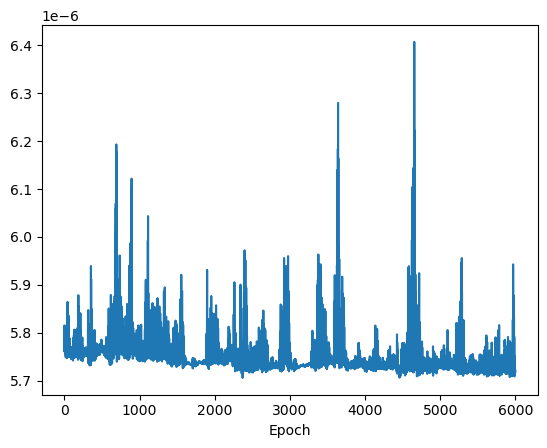

In [198]:
plt.figure()
plt.plot(model.loss_log,label='loss')
# plt.plot(model.loss_pdf_log,label='loss pdf')
# plt.plot(model.loss_Fex_log,label='loss Fex')
# plt.plot(model.loss_alpha_log,label='loss alpha')
# plt.legend()
plt.xlabel('Epoch')
# plt.yscale('log')
plt.show()

In [12]:
test_index = onp.linspace(1,19,10,dtype=int)
# index = train_index
index = test_index
p_lambda_t = t[None,:]*u_set[:,None]*(1.0 - onp.exp(-t[None,:])) * (1.0 + 2.0 * onp.sin(2.0 * onp.pi * t[None,:]))
p_lambda_t = p_lambda_t[:,:,None]
t_batch = model.norm_fac_alpha, model.norm_fac_fe, model.norm_fac_phi, model.factor_m_log, model.factor_Fex, model.factor_alpha, \
					X[index,:,:,:], p_lambda_t[index,:,:], Fex[index,:], model.ones, model.delta_t
_, t_m_log_pdf, _, _ = model.get_loss(model.params, t_batch)
print(t_m_log_pdf)

### Learned mean and std

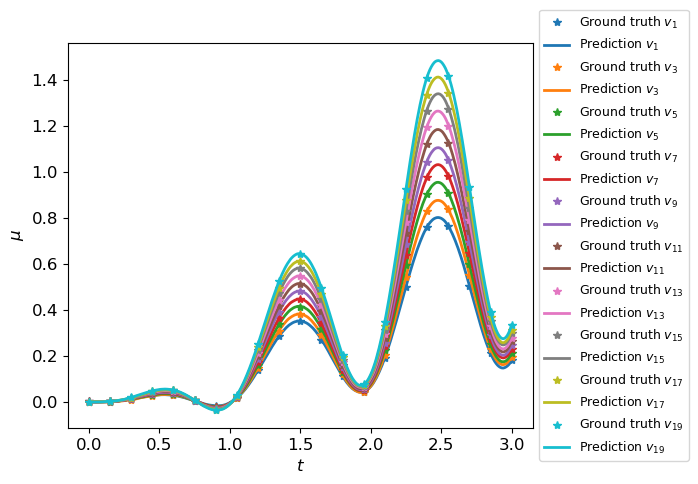

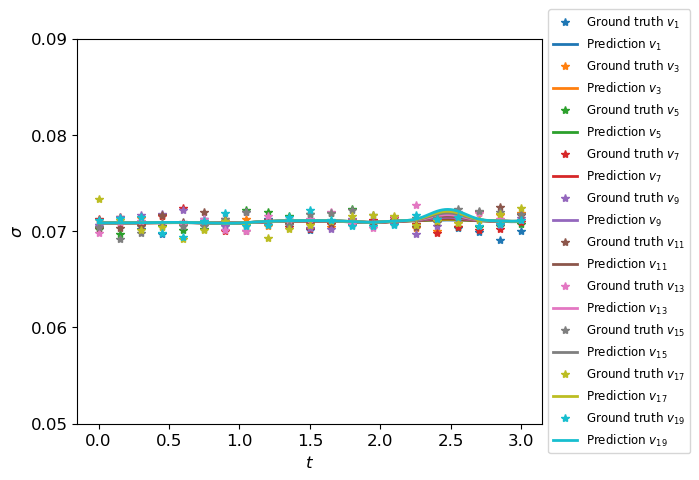

In [203]:
plt.figure(figsize=(6,5))
c_set = list(mcolors.TABLEAU_COLORS)
c_set.append('pink')
test_index = onp.linspace(1,19,10,dtype=int)
for i in range(test_index.size):
  index = test_index[i]
  p_mean, _ = model.get_predicted_mean_std(X[index:index+1,:,:,:])
  plt.plot(t,X[index,:,:].mean(axis=1),'*',markevery=15,color=c_set[i],label=r'Ground truth $v_{'+str(index)+'}$',linewidth=2)
  plt.plot(t,p_mean[0,:,0],color=c_set[i],label=r'Prediction $v_{'+str(index)+'}$',linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=9)
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\mu$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,5))
# for i in range(train_index.size):
#   index = train_index[i]
for i in range(test_index.size):
  index = test_index[i]
  _, p_std = model.get_predicted_mean_std(X[index:index+1,:,:,:])                                                                        
  plt.plot(t,X[index,:,:].std(axis=1),'*',markevery=15,color=c_set[i],label=r'Ground truth $v_{'+str(index)+'}$',linewidth=2)
  plt.plot(t,np.abs(p_std[0,:,0]),color=c_set[i],label=r'Prediction $v_{'+str(index)+'}$',linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8.5)
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks([0.05,0.06,0.07,0.08,0.09],fontsize=12)
plt.show()

Test on cosine prtocol

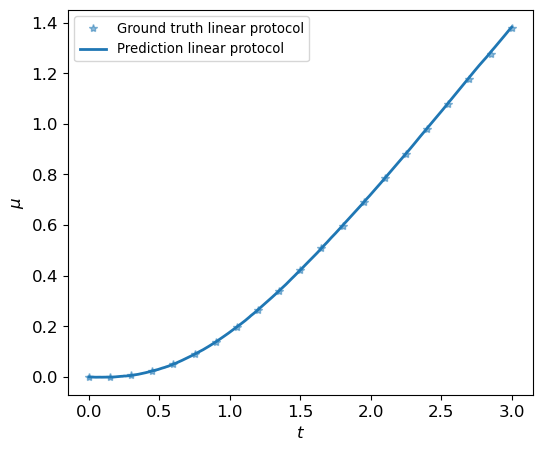

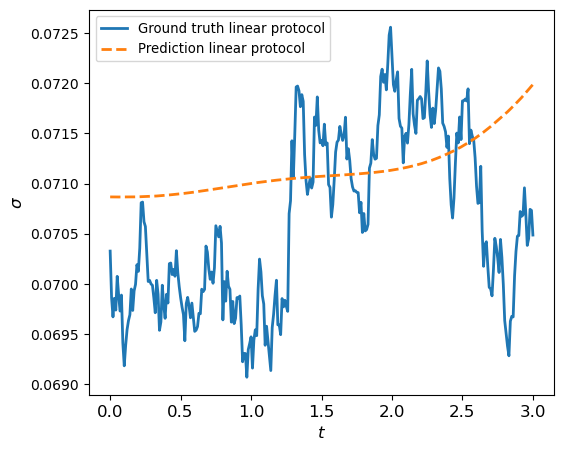

In [204]:
plt.figure(figsize=(6,5))
p_mean, p_std = model.get_predicted_mean_std(X_lin[None,:,:,:])
plt.plot(t,X_lin.mean(axis=(-1,-2)),'*',markevery=15,color=c_set[0],alpha=0.5,label='Ground truth linear protocol',linewidth=2)
plt.plot(t,p_mean[0,:,0],'-',color=c_set[0],label='Prediction linear protocol',linewidth=2)
plt.legend(fontsize=9.5)
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\mu$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,5))                                                                     
plt.plot(t,X_lin.std(axis=(-1,-2)),label='Ground truth linear protocol',linewidth=2)
plt.plot(t,np.abs(p_std[0,:,0]),'--',label='Prediction linear protocol',linewidth=2)
plt.legend(fontsize=9.5)
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma$',fontsize=12)
plt.xticks(fontsize=12)
# plt.yticks([0.0005,0.0006,0.0007,0.0008,0.0009],fontsize=12)
plt.show()

### Profiles of "internal variables"

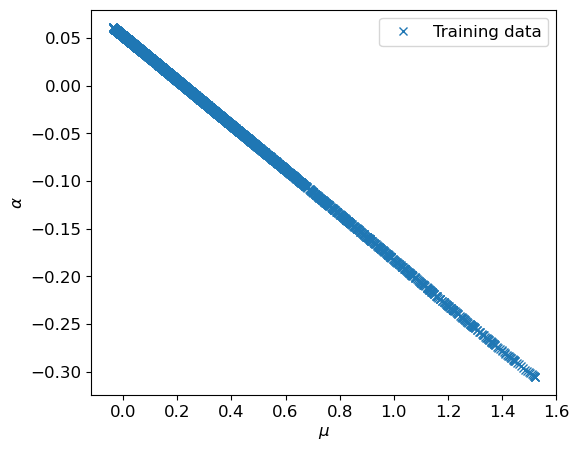

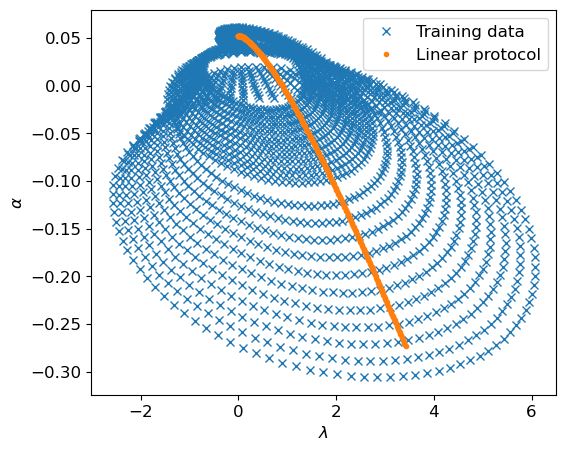

In [205]:
plt.figure(figsize=(6,5))
index = train_index
p_alpha = model.calc_internal_var(model.params['encoder'], model.params['encoder2'], X[index,:,:,:], [model.X_mean,model.X_std])
plt.plot(np.ravel(X[index,:,:,:].mean(axis=(-1,-2))),np.ravel(p_alpha),'x',label="Training data")
plt.legend(fontsize=12)
plt.xlabel(r'$\mu$',fontsize=12)
plt.ylabel(r'$\alpha$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize = (6,5))
plt.plot(np.ravel(model.lambda_t),np.ravel(p_alpha),'x',label="Training data")
p_lambda_t = t*param_u*(1.0 - onp.exp(-t))
p_alpha = model.calc_internal_var(model.params['encoder'], model.params['encoder2'], X_lin[None,:,:,:], [model.X_mean,model.X_std])
plt.plot(np.ravel(p_lambda_t),np.ravel(p_alpha),'.',label="Linear protocol")
plt.xlabel(r'$\lambda$',fontsize=12)
plt.ylabel(r'$\alpha$',fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Potentials

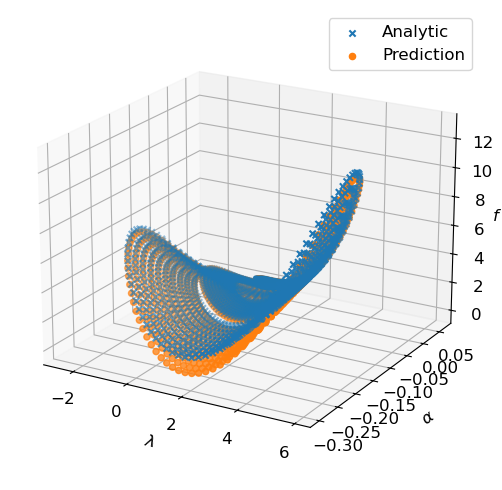

relative L2 error in fe: 8.598014%


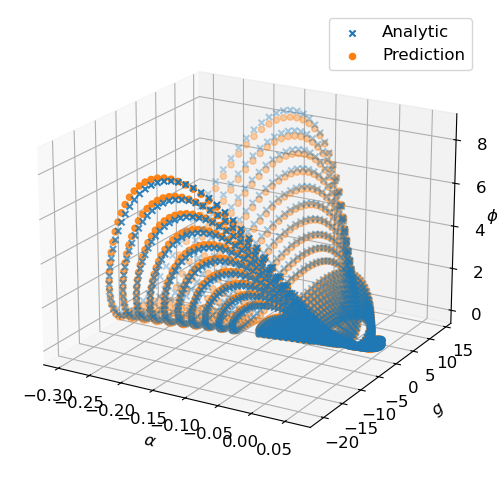

relative L2 error in phi: 4.940296%


In [212]:
# NN prediction
test_index = onp.linspace(1,19,10,dtype=int)
# index = train_index
index = test_index
p_lambda_t = t[None,:]*u_set[:,None]*(1.0 - onp.exp(-t[None,:])) * (1.0 + 2.0 * onp.sin(2.0 * onp.pi * t[None,:]))
p_lambda_t = p_lambda_t[:,:,None]
p_fe_analytic, p_phi_analytic, p_fe_nn, p_phi_nn, p_alpha_nn, p_g_internal_var_dot = model.get_test_fe_phi_solve_OVP(p_lambda_t[index,:,:], X[index,:,:,:])

fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection ="3d")
ax.scatter3D(p_lambda_t[index,:,:],p_alpha_nn,p_fe_analytic,marker='x',label='Analytic')
ax.scatter3D(p_lambda_t[index,:,:],p_alpha_nn,p_fe_nn,marker='o',label='Prediction')
ax.set_xlabel(r'$\lambda$', fontsize=12)
ax.set_ylabel(r'$\alpha$', fontsize=12)
ax.set_zlabel(r'$f$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.labelpad = 8
ax.zaxis.labelpad = -1.5
# ax.set_yticklabels(['void','-3.5','-3.0','-2.5','-2.0','-1.5','-1.0'],rotation=-15, va='center', ha='left')
ax.view_init(20, -60)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('./example1_f.png', bbox_inches='tight')
plt.show()
print('relative L2 error in fe: %f%%' % (np.sqrt(np.sum((p_fe_nn-p_fe_analytic)**2) / np.sum(p_fe_analytic**2))*100) )

fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection ="3d")
ax.scatter3D(p_alpha_nn, p_g_internal_var_dot,p_phi_analytic,marker='x',label='Analytic')
ax.scatter3D(p_alpha_nn, p_g_internal_var_dot,p_phi_nn,marker='o',label='Prediction')
ax.set_xlabel(r'$\alpha$', fontsize=12)
ax.set_ylabel('     '+r'$g$', fontsize=12)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel(r'$\phi$', fontsize=12,rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.labelpad = 8
ax.zaxis.labelpad = -4
# ax.set_yticklabels(['void','0.00000','0.00001','0.00002','0.00003','0.00004','0.00005','0.00006','0.00007'],rotation=-15, va='center', ha='left')
ax.view_init(20, -60)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('./example1_phi.png', bbox_inches='tight')
plt.show()
print('relative L2 error in phi: %f%%' % (np.sqrt(np.sum((p_phi_nn-p_phi_analytic)**2) / np.sum(p_phi_analytic**2))*100) )

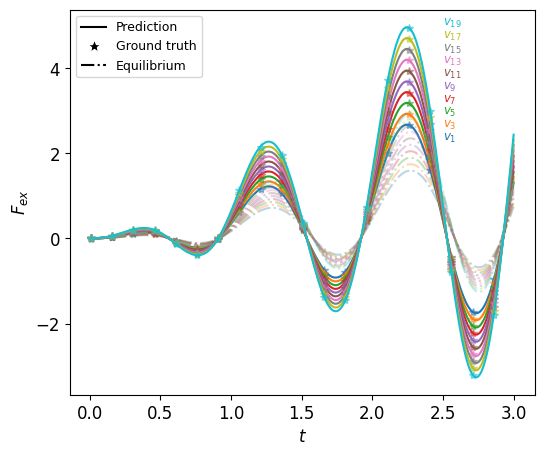

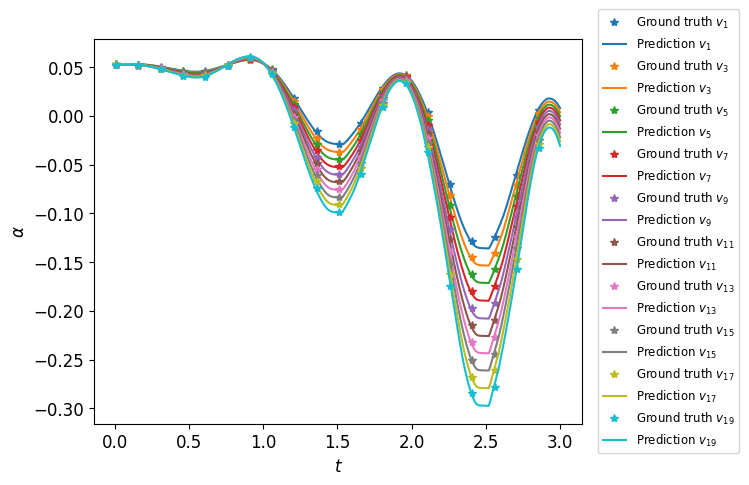

Relative L2 error of Fex: 0.1844943%
Relative L2 error of alpha: 2.7230275%


In [13]:
# NN prediction
p_lambda_t = t[None,:]*u_set[:,None]*(1.0 - onp.exp(-t[None,:])) * (1.0 + 2.0 * onp.sin(2.0 * onp.pi * t[None,:]))
p_lambda_t = p_lambda_t[:,:,None]
p_alpha, p_alpha_nn, p_Fex_nn = model.get_test_fe_phi_solve_OVP(p_lambda_t, X, mode="OVP")

test_index = onp.linspace(1,19,10,dtype=int)
# index = train_index
index = test_index

Fex_true = Fex[:,1:]

c_set = list(mcolors.TABLEAU_COLORS)
c_set.append('pink')
plt.figure(figsize=(6,5))
for i in range(len(index)):
    # plot
    plt.plot(t[1:],p_Fex_nn[index[i],:],color=c_set[i],label='Prediction $v_{' + str(index[i]) + '}$')
    plt.plot(t[1:],Fex_true[index[i],:],'*',markevery=15,color=c_set[i],alpha=0.5,label=r'Ground truth $v_{' + str(index[i]) + '}$')
    plt.plot(t[1:],0.5*k*p_lambda_t[index[i],1:,0],'-.',color=c_set[i],alpha=0.3,label='Equilibrium $v_{' + str(index[i]) + '}$')
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$F_{ex}$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='Prediction'),
                   Line2D([0], [0], marker='*', color='w', label='Ground truth',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-.', color='k', lw=1.5, label='Equilibrium')]
plt.legend(handles=legend_elements,fontsize=9)
# plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),fontsize=8.5)
plt.text(2.5,2.3,r'$v_{1}$',color=c_set[0],fontsize=8.5)
plt.text(2.5,2.6,r'$v_{3}$',color=c_set[1],fontsize=8.5)
plt.text(2.5,2.9,r'$v_{5}$',color=c_set[2],fontsize=8.5)
plt.text(2.5,3.2,r'$v_{7}$',color=c_set[3],fontsize=8.5)
plt.text(2.5,3.5,r'$v_{9}$',color=c_set[4],fontsize=8.5)
plt.text(2.5,3.8,r'$v_{11}$',color=c_set[5],fontsize=8.5)
plt.text(2.5,4.1,r'$v_{13}$',color=c_set[6],fontsize=8.5)
plt.text(2.5,4.4,r'$v_{15}$',color=c_set[7],fontsize=8.5)
plt.text(2.5,4.7,r'$v_{17}$',color=c_set[8],fontsize=8.5)
plt.text(2.5,5.0,r'$v_{19}$',color=c_set[9],fontsize=8.5)
plt.show()

plt.figure(figsize=(6.3,5))
for i in range(len(index)):
    # plot
    plt.plot(t[1:],p_alpha[index[i],:,0],'*',markevery=15,color=c_set[i],label=r'Ground truth $v_{' + str(index[i]) + '}$')
    plt.plot(t[1:],p_alpha_nn[index[i],:,0],'-',color=c_set[i],label='Prediction $v_{' + str(index[i]) + '}$')
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),fontsize=8.5)
plt.show()

num_v_par = index.size * 1

L2_err_Fex = np.sqrt((np.square(Fex_true[index,:]-p_Fex_nn[index,:])).sum()*model.delta_t/num_v_par)
L2_nrm_Fex = np.sqrt((np.square(Fex_true[index,:])).sum()*model.delta_t/num_v_par)

L2_err_alpha = np.sqrt((np.square(p_alpha[index,:,0]-p_alpha_nn[index,:,0])).sum()*model.delta_t/num_v_par)
L2_nrm_alpha = np.sqrt((np.square(p_alpha[index,:,0])).sum()*model.delta_t/num_v_par)

print("Relative L2 error of Fex: "+str(100*L2_err_Fex/L2_nrm_Fex) + "%")
print("Relative L2 error of alpha: "+str(100*L2_err_alpha/L2_nrm_alpha) + "%")

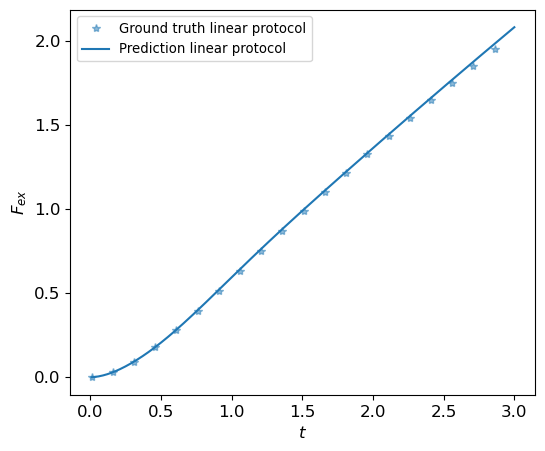

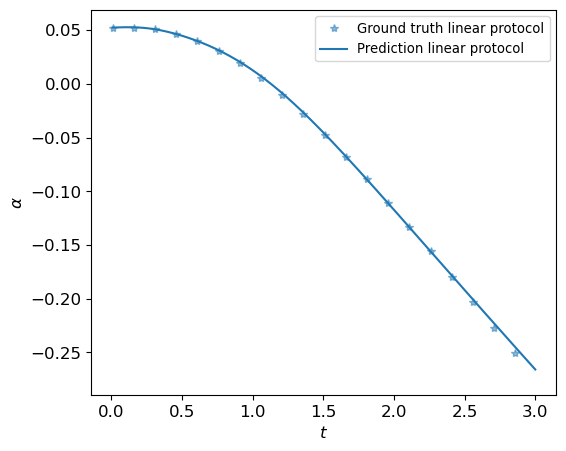

Relative L2 error of Fex: 1.2028347%
Relative L2 error of alpha: 1.7656882%


In [208]:
p_lambda_t = t[None,:]*np.array([param_u])[:,None]*(1.0 - onp.exp(-t[None,:]))
p_lambda_t = p_lambda_t[:,:,None]
p_alpha, p_alpha_nn, p_Fex_nn = model.get_test_fe_phi_solve_OVP(p_lambda_t, X_lin[None,:,:,:], mode="OVP")

plt.figure(figsize=(6,5))
plt.plot(t[1:],Fex_lin[1:],'*',markevery=15,alpha=0.5,color=c_set[0],label='Ground truth linear protocol')
plt.plot(t[1:],p_Fex_nn[0,:],color=c_set[0],label='Prediction linear protocol')
plt.legend(fontsize=9.5)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$F_{ex}$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(t[1:],p_alpha[0,:,0],'*',markevery=15,alpha=0.5,color=c_set[0],label='Ground truth linear protocol')
plt.plot(t[1:],p_alpha_nn[0,:,0],color=c_set[0],label='Prediction linear protocol')
plt.legend(fontsize=9.5)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

r_L2_err_Fex = np.sqrt((np.square(Fex_lin[1:]-p_Fex_nn[0,:])).sum() / np.square(Fex_lin[1:]).sum())
r_L2_err_alpha = np.sqrt((np.square(p_alpha-p_alpha_nn)).sum() / np.square(p_alpha).sum())

print("Relative L2 error of Fex: "+str(100*r_L2_err_Fex) + "%")
print("Relative L2 error of alpha: "+str(100*r_L2_err_alpha) + "%")
